In [1]:
# Importing dependencies
%matplotlib inline  
import os
import cv2
import time
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

In [2]:
# Is gpu available?
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    
print(device)

cuda:0


In [3]:
encoder = torch.load("models/encoder-five-epochs.pt")
encoder.to(device)
encoder = encoder.eval()
print(encoder)

Encoder(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
  )
  (mu): Sequential(
    (0): Linear(in_features=1024, out_features=32, bias=True)
  )
  (logvar): Sequential(
    (0): Linear(in_features=1024, out_features=32, bias=True)
  )
)


In [4]:
from mdnrnn import MDNRNN

rnn = MDNRNN()
rnn.to(device)
print(rnn)

MDNRNN(
  (lstm): LSTM(35, 256)
  (mdn): MDN(
    (pi): Sequential(
      (0): Linear(in_features=256, out_features=5, bias=True)
      (1): Softmax(dim=1)
    )
    (sigma): Linear(in_features=256, out_features=160, bias=True)
    (mu): Linear(in_features=256, out_features=160, bias=True)
  )
)


In [5]:
# Loss and Optimizer
from mdn import mdn_loss
from torch.optim import Adam

learning_rate = 0.001
optim = Adam(rnn.parameters(), lr=learning_rate)

In [5]:
from torch.utils.data import Dataset

class CarRacingDataset(Dataset):

    def __init__(self, data_vstacked, transform=None):
        self.observations = data_vstacked[:, 0]
        self.actions = data_vstacked[:, 1]
        self.transform = transform

    def __len__(self):
        return len(self.actions)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        observation = cv2.resize(observation, (64, 64))
        if self.transform:
            observation = self.transform(observation)
            action = torch.tensor(action)
        return observation, action

In [7]:
# Training
from torch.utils.data import DataLoader
from torchvision import transforms

tensorize = transforms.Compose([transforms.ToTensor(),])

data_dir = "../../../../../media/piyush/New Volume/dataset/"
NUM_FILES = len(os.listdir(data_dir))
NUM_TRAIN_FILES = NUM_FILES * 80 // 100
NUM_VAL_FILES = NUM_FILES - NUM_TRAIN_FILES
NUM_EPOCHS = 1
NUM_WORKERS = 8
BATCH_SIZE = 512
stats = {
    "train_loss":[],
    "val_loss":[]
}

for epoch in range(NUM_EPOCHS):
    # In an epoch
    train_loss = 0
    val_loss = 0
    h, c = MDNRNN._init_hidden(BATCH_SIZE)
    h, c = h.to(device), c.to(device)
    for file_number in range(1, NUM_TRAIN_FILES + 1):
        running_loss=0
        # For *.npy files
        print("Training batch-{}..".format(file_number))
        
        # Prepare dataset
        filename = data_dir + "batch-{}.npy".format(file_number)
        data = np.load(filename, allow_pickle=True)
        data = np.vstack((data[0], data[1], data[2], data[3]))
        data_set = CarRacingDataset(data, transform=tensorize)
        data_loader = DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)
        NUM_TRAIN_BATCHES = len(data_loader)
        
        for observation, action in data_loader:
            # Training MDNRNN
            optim.zero_grad()
            
            observation, action = observation.to(device), action.to(device)
            latent_z = encoder(observation)
            print("z", latent_z)
            z_a = torch.cat([latent_z, action], dim=-1)
            pi, mu, sigma, h_next, c_next = rnn(z_a, h, c)
            print("pi", pi, mu, sigma)
            loss = Loss(pi, sigma, mu, latent_z)
            loss.backward()
            optim.step()
            train_loss += loss.item()
            running_loss += loss.item()
            print(loss.item())
        print(running_loss/BATCH_SIZE)

    rnn = rnn.eval()
    for file_number in range(NUM_TRAIN_FILES + 1, NUM_FILES + 1):
        # For *.npy files
        print("Validating batch-{}..".format(file_number))
        
        # Prepare dataset
        filename = data_dir + "batch-{}.npy".format(file_number)
        data = np.load(filename, allow_pickle=True)
        data = np.vstack((data[0], data[1], data[2], data[3]))
        data_set = CarRacingDataset(data, transform=tensorize)
        data_loader = DataLoader(data_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=True)
        NUM_VAL_BATCHES = len(data_loader)
        
        for observation, action in data_loader:
            # Validating MDNRNN
            observation, action = observation.to(device), action.to(device)
            latent_z = encoder(observation)
            
            (pi, mu, sigma), hidden = rnn([latent_z, action, hidden])
            loss = Loss(pi, sigma, mu, latent_z)
            val_loss += loss.item()

    rnn = rnn.train()

    stats["train_loss"].append(train_loss/NUM_TRAIN_BATCHES)
    stats["val_loss"].append(val_loss/NUM_VAL_BATCHES)
    print("Epoch {}: train_loss: {} val_loss: {}".format(
        epoch + 1, stats["train_loss"][-1], stats["val_loss"][-1]))
    show_image(iter(data_loader).next()[np.random.randint(0, 64)])
plot_losses(stats)        

Training batch-1..


NameError: name 'optim' is not defined

In [10]:
torch.save(rnn, "models/mdnrnn-wo-training.pt")

In [26]:
observation, action = iter(data_loader).next()
observation, action = observation[500].to(device), action[500].to(device)
latent_z = encoder(observation.unsqueeze(0))
z_a = torch.cat([latent_z, action.unsqueeze(0)], dim=-1)
h, c = rnn._init_hidden(1)
h, c = [x.to(device) for x in (h, c)]
pi, sigma, mu, _, _ = rnn(z_a.unsqueeze(0), h.unsqueeze(0), c.unsqueeze(0))
y_preds = [torch.normal(mu.unsqueeze(0), sigma.unsqueeze(0))[:, :, i, :] for i in range(5)]
compare_x = decoder(torch.cat([x, y] + y_preds))

y tensor([[[-1.7343e-02, -6.0662e-02, -1.5797e-02, -2.2258e-02, -6.2107e-02,
           2.6263e-02, -1.4514e-02,  3.9017e-03,  2.3938e-02,  5.6532e-03,
           4.9630e-02,  3.4962e-02, -2.2062e-03,  1.8551e-02, -5.9229e-03,
          -2.2910e-02,  3.3441e-02,  7.8926e-03,  1.6763e-02,  1.7000e-02,
           2.9075e-02, -2.7174e-03, -4.6771e-02,  2.4970e-02,  1.7634e-02,
           1.7161e-02, -1.6823e-02,  1.0473e-02,  3.9788e-03,  2.4043e-02,
          -5.2696e-02,  3.7409e-02,  3.1482e-02,  6.2099e-02,  2.8007e-02,
           5.1247e-02,  2.2397e-02,  8.6895e-04, -2.0262e-02,  3.4760e-02,
          -6.7242e-03,  3.1677e-02,  3.7129e-02, -3.3772e-02,  1.5815e-03,
          -1.2020e-01, -1.0366e-01, -2.3364e-02,  2.9802e-02,  5.4655e-02,
          -4.1443e-02,  4.1462e-02,  6.8035e-02,  1.5134e-02,  6.7596e-02,
           4.5737e-02, -4.9722e-02, -1.1240e-02,  8.0979e-02,  5.1075e-02,
           7.0714e-02, -3.3030e-02,  4.1902e-02, -2.8272e-02, -9.4737e-02,
           3.0064e-02, 

NameError: name 'vae' is not defined

In [45]:
encoder = torch.load("models/encoder-five-epochs.pt")
org = encoder(observation.unsqueeze(0))

In [47]:
pred = torch.normal(mu, sigma)

In [87]:
images = decoder(pred.squeeze())

In [55]:
images.shape

torch.Size([5, 3, 64, 64])

In [83]:
def show_image(img):
    plt.imshow(img.detach().cpu().T)
    plt.show()

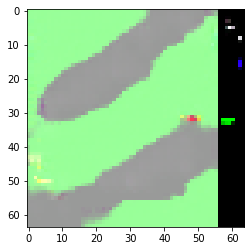

In [91]:
show_image(images[0])

In [81]:
images.shape

torch.Size([5, 3, 64, 64])

In [53]:
images.shape

torch.Size([1, 5, 32])

In [68]:
observation, action = iter(data_loader).next()
observation = observation[50].to(device)